In [4]:
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import logging
from logging import Logger
from typing import Optional

project_root = Path.cwd().resolve()
if project_root.name == "notebooks":          # notebook opened from ./notebooks
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import importlib

from src_clean.data_pipelines.silver.market_volatility_processor import VolatilityProcessor
importlib.reload(sys.modules["src_clean.data_pipelines.silver.market_volatility_processor"])

from src_clean.training.xgboost_training_pipeline_mlflow import XGBoostMLflowTrainingPipeline
importlib.reload(sys.modules["src_clean.training.xgboost_training_pipeline_mlflow"])
from src_clean.training.xgboost_training_pipeline_mlflow import XGBoostMLflowTrainingPipeline

from src_clean.training.ar_training_pipeline_mlflow import AutoregressiveOLSMLflowTrainingPipeline
importlib.reload(sys.modules["src_clean.training.ar_training_pipeline_mlflow"])
from src_clean.training.ar_training_pipeline_mlflow import AutoregressiveOLSMLflowTrainingPipeline


# AR pipeline testing

In [7]:
pipeline = AutoregressiveOLSMLflowTrainingPipeline(
    market_features_path=Path('../data_clean/gold/market/features/spx500_features.csv'),
    labels_path=None,
    news_signals_path=Path('../data_clean/gold/news/signals/spx500_news_signals.csv'),
    prediction_horizon_minutes=30,
    output_dir=Path('./AR_test'),
    experiment_name='sp500_prediction',
    enable_tuning=True,
    lag_min=1,
    lag_max=7,
    accelerate_dataset=True,
)

In [8]:
pipeline.run()

2025-11-02 15:23:28,675 - INFO - 
2025-11-02 15:23:28,675 - INFO - Autoregressive OLS Pipeline with MLflow - 30min Prediction
2025-11-02 15:23:28,676 - INFO - ================================================================================

2025-11-02 15:23:28,676 - INFO - Loading data from Gold layer...
2025-11-02 15:23:49,296 - INFO - Loaded market features: 2625395 rows, 71 columns
2025-11-02 15:23:49,305 - INFO - Inferred labels path: ..\data_clean\gold\market\labels\spx500_labels_30min.csv
2025-11-02 15:23:53,941 - INFO - Loaded gold labels: 2625365 rows, 11 columns
2025-11-02 15:23:53,960 - INFO - Merging market features with gold labels...
2025-11-02 15:23:54,885 - INFO - Merged dataset: 2625365 rows after merging
2025-11-02 15:23:54,965 - INFO - Loaded news signals: 16233 rows, 11 columns
2025-11-02 15:23:55,169 - INFO - Validating labels for 30-minute prediction...
2025-11-02 15:23:56,520 - INFO - Valid samples with labels: 2625365
2025-11-02 15:23:56,582 - INFO - Target stats

In [37]:
# Configure logging consistent with other training pipelines.
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

market_df, news_df = pipeline.load_data()
market_df = pipeline.validate_labels(market_df)

if news_df is not None and not news_df.empty:
    logger.info("News features provided but ignored for autoregressive modelling.")

if pipeline.accelerate_dataset:
    market_df = market_df.head(10000)
    logger.info("Dataset accelerated for TESTING ENVIRONMENT: using first 10,000 samples for training.")
#final_model, metrics = pipeline.train_model(market_df)

2025-11-02 12:47:37,738 - INFO - Loading data from Gold layer...


KeyboardInterrupt: 

In [25]:
market_df.to_clipboard()

In [29]:
X, y_ar, y_target, time_index, feature_names = pipeline.prepare_features(market_df, lags=2)

2025-11-02 12:39:34,577 - INFO - Prepared autoregressive features with 2 lags (9997 samples, 4 features).


In [30]:
X.head(35)

,const,return_30,return_30_lag1,return_30_lag2
0,1.0,-0.051058,-0.051064,-0.028377
1,1.0,-0.056728,-0.051058,-0.051064
2,1.0,-0.039721,-0.056728,-0.051058
3,1.0,-0.085087,-0.039721,-0.056728
4,1.0,-0.068085,-0.085087,-0.039721
5,1.0,-0.062422,-0.068085,-0.085087
6,1.0,-0.051078,-0.062422,-0.068085
7,1.0,-0.090806,-0.051078,-0.062422
8,1.0,-0.085126,-0.090806,-0.051078
9,1.0,-0.170232,-0.085126,-0.090806


In [31]:
y_ar, y_target

(0      -0.056728
 1      -0.039721
 2      -0.085087
 3      -0.068085
 4      -0.062422
           ...   
 9992   -0.393746
 9993   -0.393838
 9994   -0.469049
 9995   -0.480574
 9996   -0.393952
 Name: y_ar, Length: 9997, dtype: float64,
 0      -0.011352
 1      -0.017028
 2       0.000000
 3      -0.028387
 4      -0.005678
           ...   
 9992    0.011612
 9993    0.110452
 9994    0.122107
 9995    0.209448
 9996    0.215266
 Name: target, Length: 9997, dtype: float64)

# XGB pipeline testing

In [5]:
pipeline = XGBoostMLflowTrainingPipeline(
    market_features_path=Path('../data_clean/gold/market/features/spx500_features.csv'),
    labels_path=None,
    news_signals_path=Path('../data_clean/gold/news/signals/spx500_news_signals.csv'),
    prediction_horizon_minutes=30,
    output_dir=Path('./xgb_test'),
    task='regression',
    experiment_name='sp500_prediction',
    enable_tuning=True,
    accelerate_dataset=True,
    stage1_n_trials=30,
    stage2_n_trials=30
)

In [6]:
pipeline.run()

2025-11-02 15:40:44,811 - INFO - 
2025-11-02 15:40:44,812 - INFO - XGBoost Training Pipeline with MLflow - 30min Prediction
2025-11-02 15:40:44,813 - INFO - ================================================================================

2025-11-02 15:40:44,813 - INFO - Loading data from Gold layer...
2025-11-02 15:41:02,708 - INFO - Loaded market features: 2625395 rows, 71 columns
2025-11-02 15:41:02,713 - INFO - Inferred labels path: ..\data_clean\gold\market\labels\spx500_labels_30min.csv
2025-11-02 15:41:07,206 - INFO - Loaded gold labels: 2625365 rows, 11 columns
2025-11-02 15:41:07,217 - INFO - Merging market features with gold labels...
2025-11-02 15:41:08,040 - INFO - Merged dataset: 2625365 rows after merging
2025-11-02 15:41:08,109 - INFO - Loaded news signals: 16233 rows, 11 columns
2025-11-02 15:41:08,269 - INFO - Validating labels for 30-minute prediction...
2025-11-02 15:41:09,442 - INFO - Valid samples with labels: 2625365
2025-11-02 15:41:09,484 - INFO - Target stats: 

In [4]:
market_df, news_df = pipeline.load_data()

# Validate labels are present
market_df = pipeline.validate_labels(market_df)

# Merge with news
combined_df = pipeline.merge_market_news(market_df, news_df)

# Prepare features
X, y, time_index, feature_names = pipeline.prepare_features(combined_df)

2025-11-02 03:09:45,004 - INFO - Loading data from Gold layer...
2025-11-02 03:10:01,076 - INFO - Loaded market features: 2625395 rows, 71 columns
2025-11-02 03:10:01,078 - INFO - Inferred labels path: ..\data_clean\gold\market\labels\spx500_labels_30min.csv
2025-11-02 03:10:05,453 - INFO - Loaded gold labels: 2625365 rows, 11 columns
2025-11-02 03:10:05,454 - INFO - Merging market features with gold labels...
2025-11-02 03:10:06,198 - INFO - Merged dataset: 2625365 rows after merging
2025-11-02 03:10:06,278 - INFO - Loaded news signals: 16233 rows, 11 columns
2025-11-02 03:10:06,468 - INFO - Validating labels for 30-minute prediction...
2025-11-02 03:10:07,549 - INFO - Valid samples with labels: 2625365
2025-11-02 03:10:07,579 - INFO - Target stats: mean=0.000794, std=0.130459
2025-11-02 03:10:08,737 - INFO - Merging market features with news signals. Market Feature Initial Shape: (2625365, 76)
2025-11-02 03:10:10,167 - INFO - Merged dataset shape: (2625365, 90)
2025-11-02 03:10:10,17

In [5]:
model, metrics = pipeline.train_model(X, y, time_index, feature_names)

2025-11-02 03:10:22,363 - INFO - Training XGBoost model with MLflow tracking...
2025-11-02 03:10:22,363 - INFO - 
2025-11-02 03:10:22,363 - INFO - TEMPORAL DATA SPLITTING
2025-11-02 03:10:22,363 - INFO - ================================================================================
2025-11-02 03:10:22,904 - INFO - Total samples: 2625365
2025-11-02 03:10:22,908 - INFO - Train: 1575219 samples (60%) | 2020-10-13 16:25:00+00:00 to 2023-10-12 14:03:00+00:00
2025-11-02 03:10:22,908 - INFO - Val:   525073 samples (20%) | 2023-10-12 14:04:00+00:00 to 2024-10-11 05:16:00+00:00
2025-11-02 03:10:22,908 - INFO - Test:  262536 samples (10%) | 2024-10-11 05:17:00+00:00 to 2025-04-11 12:52:00+00:00
2025-11-02 03:10:22,908 - INFO - OOT:   262537 samples (10%) | 2025-04-11 12:53:00+00:00 to 2025-10-10 20:29:00+00:00
2025-11-02 03:10:22,908 - INFO - ================================================================================

2025-11-02 03:10:24,094 - INFO - Performing hyperparameter tuning on tr

# Plotting

C:\Users\user\AppData\Local\Temp\ipykernel_4704\2743566215.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


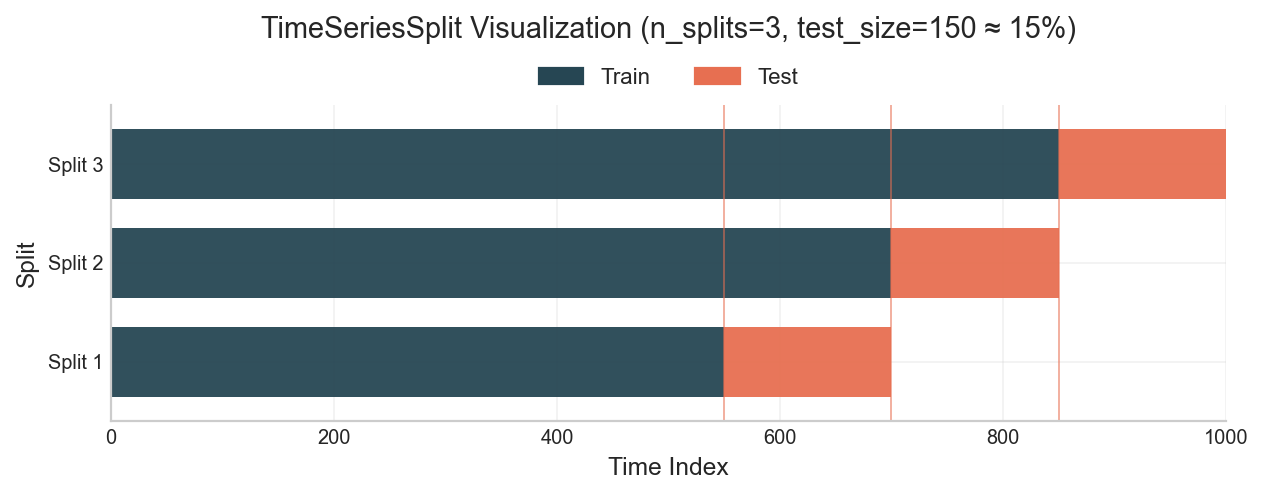

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

# Style/rcParams tuned for an academic look
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams.update({
    'figure.dpi': 160,
    'savefig.dpi': 160,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.labelsize': 11,
    'axes.titlesize': 13,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.frameon': False,
    'grid.alpha': 0.25,
})

# Synthetic time series
n_samples = 1000
X = np.arange(n_samples)

# TimeSeriesSplit with fixed test size
test_size = int(0.15 * n_samples)
splitter = TimeSeriesSplit(n_splits=3, test_size=test_size)

# Colors (colorblind-friendly)
train_color = '#264653'  # deep teal
test_color  = '#e76f51'  # salmon

fig, ax = plt.subplots(figsize=(8, 3.2), layout='constrained')

bar_height = 0.7
for i, (train_idx, test_idx) in enumerate(splitter.split(X)):
    # Convert indices to contiguous spans
    train_span = (int(train_idx.min()), int(train_idx.max() - train_idx.min() + 1))
    test_span  = (int(test_idx.min()),  int(test_idx.max()  - test_idx.min()  + 1))

    # Horizontal bars
    ax.broken_barh([train_span], (i - bar_height/2, bar_height), facecolors=train_color, alpha=0.95)
    ax.broken_barh([test_span],  (i - bar_height/2, bar_height), facecolors=test_color,  alpha=0.95)

    # Mark test start
    ax.axvline(test_idx.min(), color=test_color, lw=0.8, alpha=0.6)

# Title and labels
title_text = (
    f"TimeSeriesSplit Visualization "
    f"(n_splits={splitter.n_splits}, test_size={test_size} ≈ {test_size/n_samples:.0%})"
)
ax.set_title(title_text, pad=30)
ax.set_xlabel("Time Index")
ax.set_ylabel("Split")

# Ticks and limits
ax.set_yticks(range(splitter.n_splits), [f"Split {j+1}" for j in range(splitter.n_splits)])
ax.set_xlim(0, n_samples)
ax.set_ylim(-0.6, splitter.n_splits - 1 + 0.6)

# Legend
handles = [Patch(color=train_color, label="Train"),
           Patch(color=test_color,  label="Test")]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=2)

plt.tight_layout()
# Optional: save high-res
# plt.savefig("timeseries_split.png", bbox_inches="tight")

plt.show()